In [5]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import cv2
import random

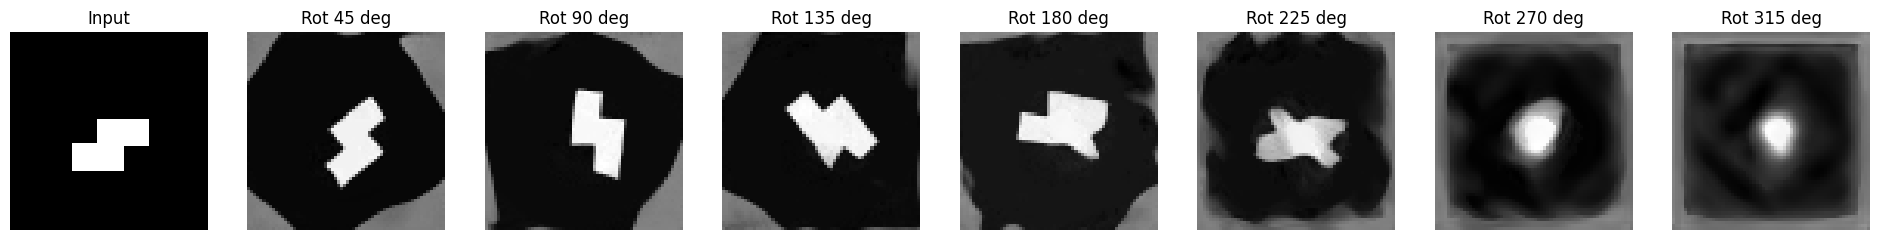

In [7]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
MODEL_PATH = "models/rotator_l1_100e_10k.pth"

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class FastRotator(nn.Module):
    def __init__(self, backbone_dim=384, flow_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.angle_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.cond_proj = nn.Linear(backbone_dim, flow_dim*4)

        self.inc = DoubleConv(1, flow_dim)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim, flow_dim*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim*2, flow_dim*4))

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(flow_dim*6, flow_dim*2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DoubleConv(flow_dim*3, flow_dim)

        self.outc = nn.Conv2d(flow_dim, 1, kernel_size=1)

    def forward(self, x_t, t, dino_emb, target_angle_deg):
        t_emb = self.time_mlp(t)
        d_emb = self.cond_proj(dino_emb)
        a_emb = self.angle_mlp(target_angle_deg / 360.0)
        global_cond = (t_emb + d_emb + a_emb).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x3 = x3 + global_cond

        x = self.conv1(torch.cat([self.up1(x3), x2], dim=1))
        x = self.conv2(torch.cat([self.up2(x), x1], dim=1))
        return self.outc(x)

model = FastRotator().to(DEVICE)
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(MODEL_PATH)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

dino = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()

def get_dino_embedding(img_64_tensor):
    img = (img_64_tensor * 0.5) + 0.5
    img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
    img = img.repeat(1, 3, 1, 1)
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = norm(img)
    with torch.no_grad():
        emb = dino.forward_features(img)[:, 0, :]
    return emb

# Build a small test sample like the exhaustive search dataset
CHIRAL_SHAPES = {'L': [(0,-1),(0,0),(0,1),(1,1)], 'Z': [(0,0),(-1,0),(0,1),(1,1)], 'S': [(0,0),(1,0),(0,1),(-1,1)]}
key = random.choice(list(CHIRAL_SHAPES.keys()))
img_a_np = np.zeros((64, 64), dtype=np.uint8)
for dx, dy in CHIRAL_SHAPES[key]:
    x, y = 32 + dx*8 - 4, 32 + dy*8 - 4
    cv2.rectangle(img_a_np, (x, y), (x+8, y+8), 255, -1)

def norm(x):
    return (torch.tensor(x).float().unsqueeze(0)/255.0 - 0.5)/0.5

sample_img = norm(img_a_np).unsqueeze(0).to(DEVICE)  # (1,1,64,64)

@torch.no_grad()
def apply_rotation(model, base_img, base_emb, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    target_ang = torch.full((B, 1), angle_deg, device=DEVICE)
    for i in range(steps):
        t = torch.full((B, 1), i/steps, device=DEVICE)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
    return curr

sample_emb = get_dino_embedding(sample_img)

angles = [45, 90, 135, 180, 225, 270, 315]
fig, axes = plt.subplots(1, len(angles) + 1, figsize=(3 * (len(angles) + 1), 3))
axes[0].imshow(sample_img[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")
axes[0].axis('off')

for i, ang in enumerate(angles):
    out = apply_rotation(model, sample_img, sample_emb, float(ang))
    axes[i+1].imshow(out[0,0].cpu(), cmap='gray')
    axes[i+1].set_title(f"Rot {ang} deg")
    axes[i+1].axis('off')

plt.show()

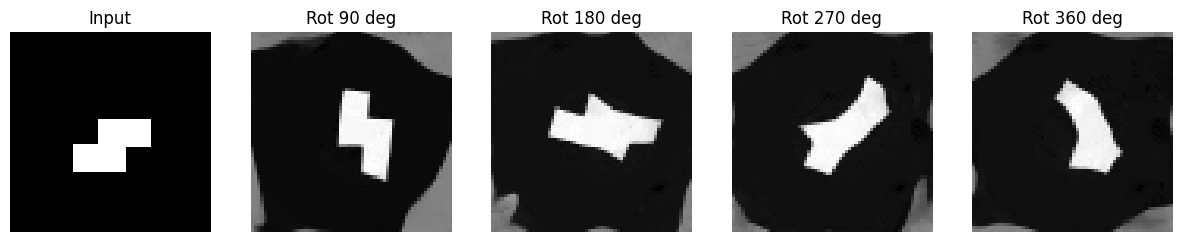

In [8]:
# Recursive 45 deg rotations
# Start from the sample image and keep rotating the output by +45 deg
step_deg = 90
num_steps = int(360 / step_deg)

curr = sample_img.clone()
# Keep embedding fixed to the identity of the original sample
base_emb = sample_emb

fig, axes = plt.subplots(1, num_steps + 1, figsize=(3 * (num_steps + 1), 3))
axes[0].imshow(curr[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")
axes[0].axis('off')

for i in range(num_steps):
    curr = apply_rotation(model, curr, base_emb, float(step_deg))
    axes[i+1].imshow(curr[0,0].cpu(), cmap='gray')
    axes[i+1].set_title(f"Rot {(i+1)*step_deg} deg")
    axes[i+1].axis('off')

plt.show()

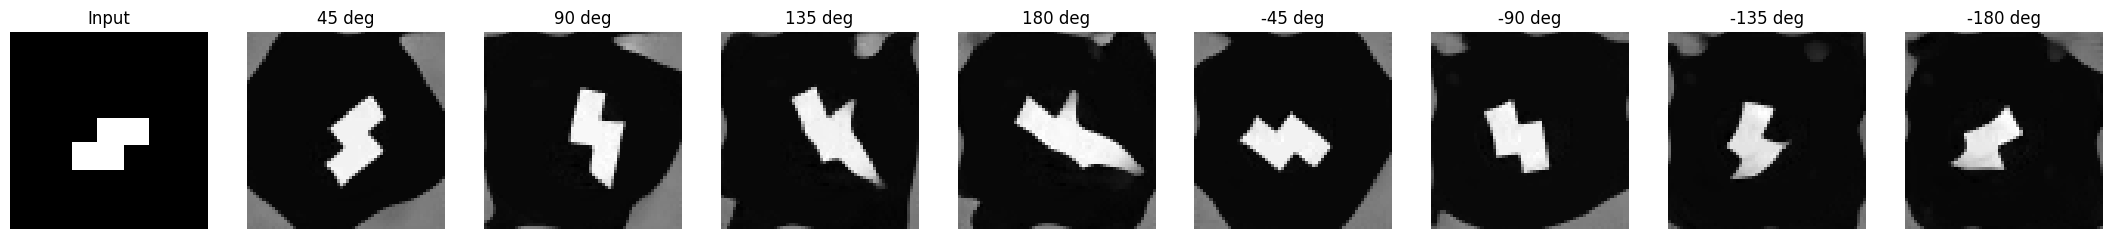

In [9]:
# Split-direction rotation: +180 and -180 from clean starts
step_deg = 45
steps_half = int(180 / step_deg)

fig, axes = plt.subplots(1, (steps_half * 2) + 1, figsize=(3 * ((steps_half * 2) + 1), 3))

# Show input first
axes[0].imshow(sample_img[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")
axes[0].axis('off')

# Positive direction 
curr_pos = sample_img.clone()
for i in range(steps_half):
    curr_pos = apply_rotation(model, curr_pos, sample_emb, float(step_deg))
    axes[i+1].imshow(curr_pos[0,0].cpu(), cmap='gray')
    axes[i+1].set_title(f"{(i+1)*step_deg} deg")
    axes[i+1].axis('off')

# Negative direction from a fresh start
curr_neg = sample_img.clone()
for j in range(steps_half):
    curr_neg = apply_rotation(model, curr_neg, sample_emb, float(-step_deg))
    axes[steps_half + j + 1].imshow(curr_neg[0,0].cpu(), cmap='gray')
    axes[steps_half + j + 1].set_title(f"{- (j+1)*step_deg} deg")
    axes[steps_half + j + 1].axis('off')

plt.show()


In [ ]:
N_SAMPLES = 1000
SEARCH_STEP_DEG = 5
ROT_STEPS = 10
THRESHOLD = None

CHIRAL_SHAPES = {
    'L': [(0,-1),(0,0),(0,1),(1,1)],
    'Z': [(0,0),(-1,0),(0,1),(1,1)],
    'S': [(0,0),(1,0),(0,1),(-1,1)]
}

def draw_shape_np(name, size=64):
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block = size // 8
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + dx * block - block // 2
        y = center + dy * block - block // 2
        cv2.rectangle(img, (x, y), (x + block, y + block), 255, -1)
    return img

def norm_tensor(x):
    return (torch.tensor(x).float().unsqueeze(0) / 255.0 - 0.5) / 0.5

@torch.no_grad()
def solve_exhaustive(model, img_a, img_b, search_step=5, steps=10):
    model.eval()
    emb_a = get_dino_embedding(img_a)
    best_loss = float('inf')
    best_angle = 0
    best_img = None

    for ang in range(0, 360, search_step):
        pred = apply_rotation(model, img_a, emb_a, float(ang), steps=steps)
        loss = torch.mean((pred - img_b) ** 2).item()
        if loss < best_loss:
            best_loss = loss
            best_angle = ang
            best_img = pred

    return best_loss, best_angle, best_img

# Run experiment
y_true = []
y_scores = []
errors = []

for _ in range(N_SAMPLES):
    key = random.choice(list(CHIRAL_SHAPES.keys()))
    base_np = draw_shape_np(key, 64)

    angle = random.randint(0, 359)
    M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)

    is_same = (random.random() > 0.5)
    if is_same:
        img_b_np = cv2.warpAffine(base_np, M, (64, 64))
        label = 1.0
    else:
        mirrored = cv2.flip(base_np, 1)
        img_b_np = cv2.warpAffine(mirrored, M, (64, 64))
        label = 0.0

    img_a = norm_tensor(base_np).unsqueeze(0).to(DEVICE)
    img_b = norm_tensor(img_b_np).unsqueeze(0).to(DEVICE)

    best_loss, best_angle, _ = solve_exhaustive(model, img_a, img_b, search_step=SEARCH_STEP_DEG, steps=ROT_STEPS)

    y_true.append(label)
    errors.append(best_loss)
    y_scores.append(-best_loss)

# Thresholding and accuracy
same_errors = [e for e, t in zip(errors, y_true) if t == 1.0]
diff_errors = [e for e, t in zip(errors, y_true) if t == 0.0]

if THRESHOLD is None:
    THRESHOLD = (np.mean(same_errors) + np.mean(diff_errors)) / 2.0

preds = [1.0 if e < THRESHOLD else 0.0 for e in errors]
acc = np.mean([p == t for p, t in zip(preds, y_true)])

print(f"Accuracy: {acc*100:.2f}%")
print(f"Threshold used (MSE): {THRESHOLD:.6f}")

plt.figure(figsize=(10, 5))
plt.hist([s for s, t in zip(y_scores, y_true) if t == 1.0], bins=20, alpha=0.7, color='green', label='Same (Rotated)')
plt.hist([s for s, t in zip(y_scores, y_true) if t == 0.0], bins=20, alpha=0.7, color='red', label='Different (Mirrored)')
plt.title(f"Rotator Exhaustive Search Distribution (Acc: {acc:.2f})")
plt.xlabel("Negative MSE (Higher is Better)")
plt.legend()
plt.show()

Accuracy: 46.00%
AUC: 0.4608
Threshold used (MSE): 0.263392


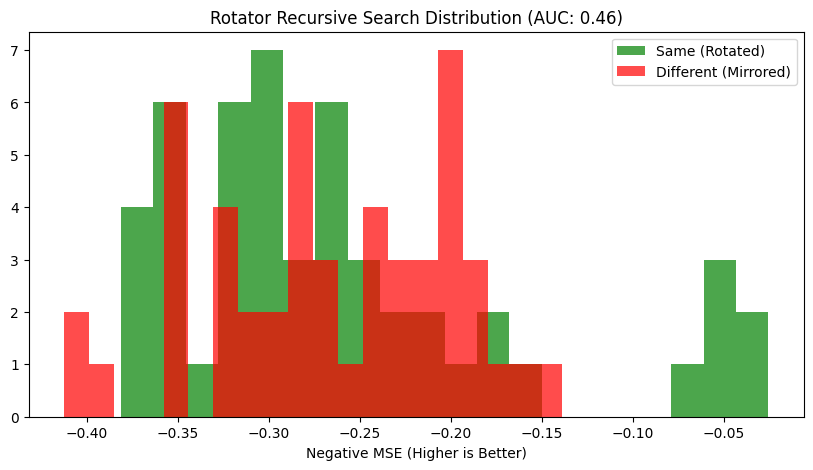

In [30]:
import sklearn.metrics as metrics

N_SAMPLES = 100
BASE_STEP_DEG = 5.0
MIN_STEP_DEG = 2.0
MAX_STEP_DEG = 15.0
ROT_STEPS = 10
THRESHOLD = None

@torch.no_grad()
def mse_err(a, b):
    return torch.mean((a - b) ** 2).item()

@torch.no_grad()
def search_recursive_adaptive(model, img_a, img_b,
                              base_step=5.0, min_step=2.0, max_step=15.0, steps=10):
    model.eval()
    emb_a = get_dino_embedding(img_a)

    def walk(direction):
        angle = 0.0
        curr = img_a.clone()
        best_loss = float('inf')
        best_angle = 0.0
        best_img = curr

        initial_err = mse_err(curr, img_b)
        prev_err = initial_err
        step = base_step

        while abs(angle) < 180.0 - 1e-6:
            remaining = 180.0 - abs(angle)
            step = min(step, remaining)

            curr = apply_rotation(model, curr, emb_a, float(direction * step), steps=steps)
            angle += direction * step

            err = mse_err(curr, img_b)
            if err < best_loss:
                best_loss, best_angle, best_img = err, angle, curr

            # Momentum: if far, speed up; if getting closer, slow down
            if err < prev_err:
                step = max(step * 0.85, min_step)
            else:
                step = min(step * 1.15, max_step)

            if err < initial_err * 0.6:
                step = max(step * 0.8, min_step)
            elif err > initial_err * 0.9:
                step = min(step * 1.2, max_step)

            prev_err = err

        return best_loss, best_angle, best_img

    pos = walk(direction=1)
    neg = walk(direction=-1)

    return pos if pos[0] <= neg[0] else neg

# Run experiment
y_true = []
y_scores = []
errors = []

for _ in range(N_SAMPLES):
    key = random.choice(list(CHIRAL_SHAPES.keys()))
    base_np = draw_shape_np(key, 64)

    angle = random.randint(0, 359)
    M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)

    is_same = (random.random() > 0.5)
    if is_same:
        img_b_np = cv2.warpAffine(base_np, M, (64, 64))
        label = 1.0
    else:
        mirrored = cv2.flip(base_np, 1)
        img_b_np = cv2.warpAffine(mirrored, M, (64, 64))
        label = 0.0

    img_a = norm_tensor(base_np).unsqueeze(0).to(DEVICE)
    img_b = norm_tensor(img_b_np).unsqueeze(0).to(DEVICE)

    best_loss, best_angle, _ = search_recursive_adaptive(
        model, img_a, img_b,
        base_step=BASE_STEP_DEG, min_step=MIN_STEP_DEG, max_step=MAX_STEP_DEG,
        steps=ROT_STEPS
    )

    y_true.append(label)
    errors.append(best_loss)
    y_scores.append(-best_loss)

# Threshold and accuracy
same_errors = [e for e, t in zip(errors, y_true) if t == 1.0]
diff_errors = [e for e, t in zip(errors, y_true) if t == 0.0]

if THRESHOLD is None:
    THRESHOLD = (np.mean(same_errors) + np.mean(diff_errors)) / 2.0

preds = [1.0 if e < THRESHOLD else 0.0 for e in errors]
acc = np.mean([p == t for p, t in zip(preds, y_true)])

auc = metrics.roc_auc_score(y_true, y_scores)
print(f"Accuracy: {acc*100:.2f}%")
print(f"AUC: {auc:.4f}")
print(f"Threshold used (MSE): {THRESHOLD:.6f}")

plt.figure(figsize=(10, 5))
plt.hist([s for s, t in zip(y_scores, y_true) if t == 1.0], bins=20, alpha=0.7, color='green', label='Same (Rotated)')
plt.hist([s for s, t in zip(y_scores, y_true) if t == 0.0], bins=20, alpha=0.7, color='red', label='Different (Mirrored)')
plt.title(f"Rotator Recursive Search Distribution (AUC: {auc:.2f})")
plt.xlabel("Negative MSE (Higher is Better)")
plt.legend()
plt.show()


Sample 1: angle 164 deg
Best same: step 6 | MSE 0.325783
Best mir:  step 6 | MSE 0.235785
Decision (closest match): mirrored


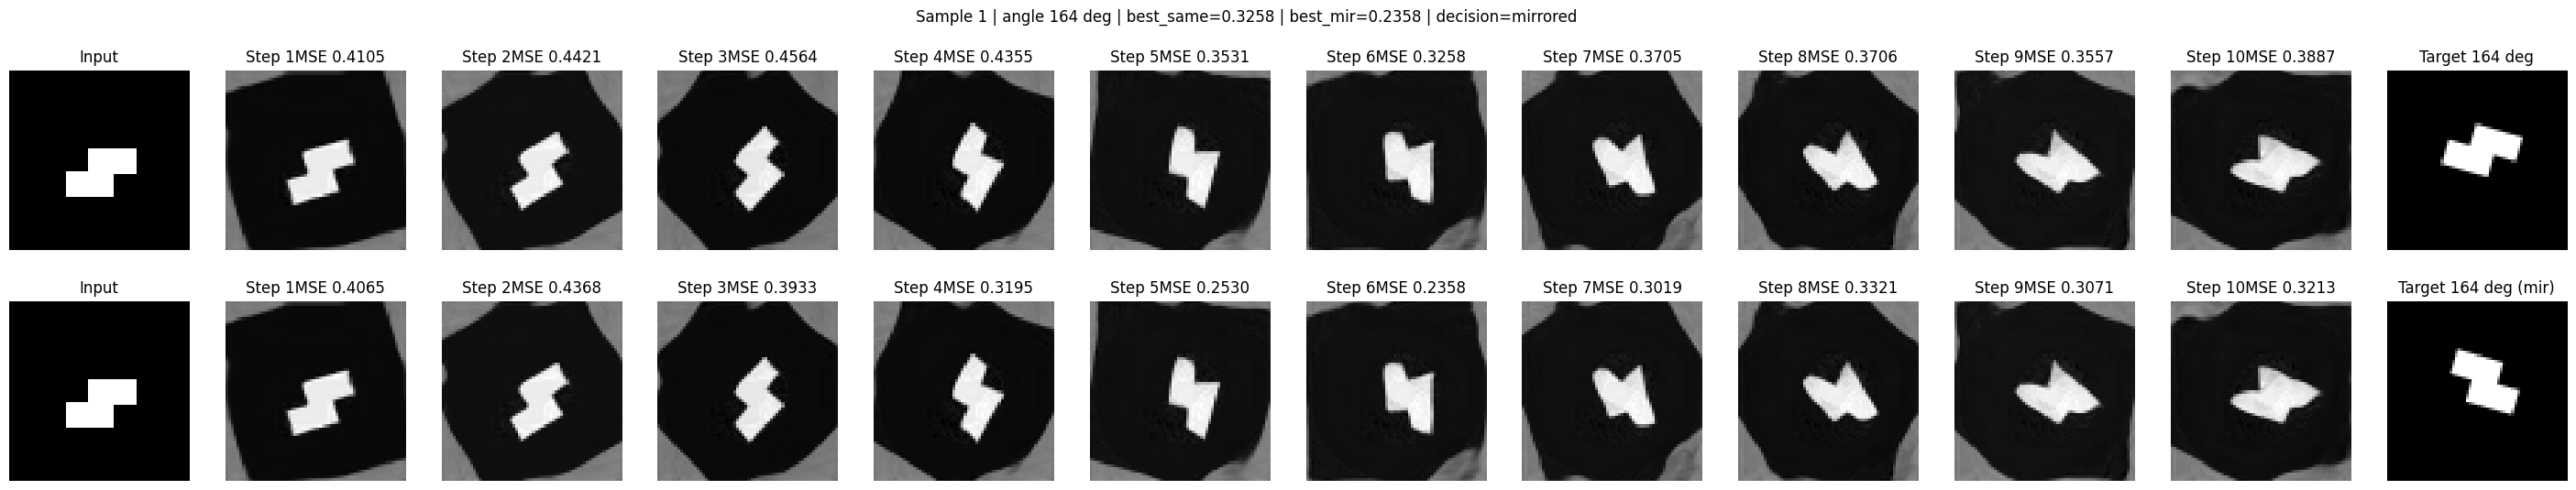

Sample 2: angle 38 deg
Best same: step 10 | MSE 0.143390
Best mir:  step 0 | MSE 0.195580
Decision (closest match): same


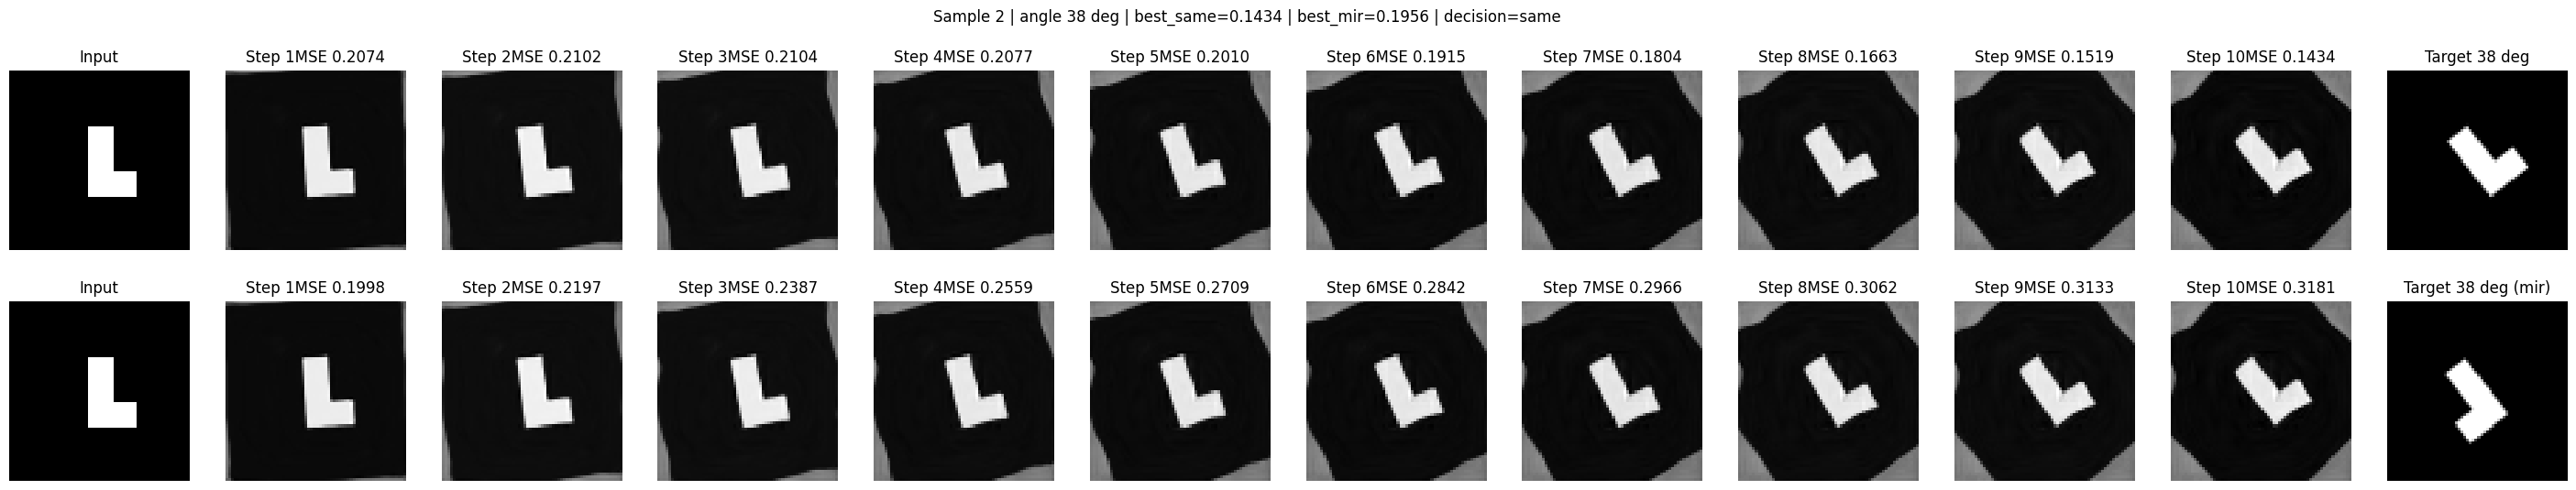

In [56]:
steps_vis = 10
num_samples = 2

@torch.no_grad()
def rotate_steps(model, base_img, base_emb, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    target_ang = torch.full((B, 1), angle_deg, device=DEVICE)
    frames = [curr.clone()]
    for i in range(steps):
        t = torch.full((B, 1), i / steps, device=DEVICE)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
        frames.append(curr.clone())
    return frames

@torch.no_grad()
def mse(a, b):
    return torch.mean((a - b) ** 2).item()

for s in range(num_samples):
    key = random.choice(list(CHIRAL_SHAPES.keys()))
    base_np = draw_shape_np(key, 64)
    base = norm_tensor(base_np).unsqueeze(0).to(DEVICE)
    base_emb = get_dino_embedding(base)

    angle = random.randint(0, 359)
    angle_signed = angle if angle <= 180 else angle - 360

    M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)
    same_np = cv2.warpAffine(base_np, M, (64, 64))
    mir_np = cv2.warpAffine(cv2.flip(base_np, 1), M, (64, 64))

    same = norm_tensor(same_np).unsqueeze(0).to(DEVICE)
    mir = norm_tensor(mir_np).unsqueeze(0).to(DEVICE)

    frames_same = rotate_steps(model, base, base_emb, float(angle_signed), steps=steps_vis)
    frames_mir = rotate_steps(model, base, base_emb, float(angle_signed), steps=steps_vis)

    mse_same_steps = [mse(f, same) for f in frames_same]
    mse_mir_steps = [mse(f, mir) for f in frames_mir]

    best_same = min(mse_same_steps)
    best_mir = min(mse_mir_steps)
    best_same_idx = int(np.argmin(mse_same_steps))
    best_mir_idx = int(np.argmin(mse_mir_steps))

    decision = 'same' if best_same < best_mir else 'mirrored'

    print(f"Sample {s+1}: angle {angle_signed} deg")
    print(f"Best same: step {best_same_idx} | MSE {best_same:.6f}")
    print(f"Best mir:  step {best_mir_idx} | MSE {best_mir:.6f}")
    print(f"Decision (closest match): {decision}")

    cols = steps_vis + 2
    fig, axes = plt.subplots(2, cols, figsize=(3 * cols, 6))
    fig.suptitle(
        f"Sample {s+1} | angle {angle_signed} deg | best_same={best_same:.4f} | best_mir={best_mir:.4f} | decision={decision}"
    )

    # Same row
    axes[0, 0].imshow(base[0,0].cpu(), cmap='gray')
    axes[0, 0].set_title("Input")
    axes[0, 0].axis('off')
    for i in range(steps_vis):
        axes[0, i+1].imshow(frames_same[i+1][0,0].cpu(), cmap='gray')
        axes[0, i+1].set_title(f"Step {i+1}MSE {mse_same_steps[i+1]:.4f}")
        axes[0, i+1].axis('off')
    axes[0, -1].imshow(same[0,0].cpu(), cmap='gray')
    axes[0, -1].set_title(f"Target {angle_signed} deg")
    axes[0, -1].axis('off')

    # Mirrored row
    axes[1, 0].imshow(base[0,0].cpu(), cmap='gray')
    axes[1, 0].set_title("Input")
    axes[1, 0].axis('off')
    for i in range(steps_vis):
        axes[1, i+1].imshow(frames_mir[i+1][0,0].cpu(), cmap='gray')
        axes[1, i+1].set_title(f"Step {i+1}MSE {mse_mir_steps[i+1]:.4f}")
        axes[1, i+1].axis('off')
    axes[1, -1].imshow(mir[0,0].cpu(), cmap='gray')
    axes[1, -1].set_title(f"Target {angle_signed} deg (mir)")
    axes[1, -1].axis('off')

    plt.show()


In [ ]:
N_SAMPLES = 100
steps_eval = 10

@torch.no_grad()
def rotate_steps(model, base_img, base_emb, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    target_ang = torch.full((B, 1), angle_deg, device=DEVICE)
    frames = [curr.clone()]
    for i in range(steps):
        t = torch.full((B, 1), i / steps, device=DEVICE)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
        frames.append(curr.clone())
    return frames

@torch.no_grad()
def mse(a, b):
    return torch.mean((a - b) ** 2).item()

y_true = []
y_scores = []
y_pred = []

for _ in range(N_SAMPLES):
    key = random.choice(list(CHIRAL_SHAPES.keys()))
    base_np = draw_shape_np(key, 64)
    base = norm_tensor(base_np).unsqueeze(0).to(DEVICE)
    base_emb = get_dino_embedding(base)

    angle = random.randint(0, 359)
    angle_signed = angle if angle <= 180 else angle - 360

    M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)

    is_same = (random.random() > 0.5)
    if is_same:
        target_np = cv2.warpAffine(base_np, M, (64, 64))
        label = 1.0
    else:
        target_np = cv2.warpAffine(cv2.flip(base_np, 1), M, (64, 64))
        label = 0.0

    target = norm_tensor(target_np).unsqueeze(0).to(DEVICE)

    frames = rotate_steps(model, base, base_emb, float(angle_signed), steps=steps_eval)
    mse_steps = [mse(f, target) for f in frames]
    best_mse = min(mse_steps)

    # Compare against mirrored hypothesis (same rotation but target is mirrored)
    # Use score = best_mir - best_same so higher => same
    target_mir_np = cv2.warpAffine(cv2.flip(base_np, 1), M, (64, 64))
    target_mir = norm_tensor(target_mir_np).unsqueeze(0).to(DEVICE)
    mse_steps_mir = [mse(f, target_mir) for f in frames]
    best_mse_mir = min(mse_steps_mir)

    score = best_mse_mir - best_mse
    pred = 1.0 if best_mse < best_mse_mir else 0.0

    y_true.append(label)
    y_scores.append(score)
    y_pred.append(pred)

acc = np.mean([p == t for p, t in zip(y_pred, y_true)])
auc = metrics.roc_auc_score(y_true, y_scores)

print(f"Accuracy: {acc*100:.2f}%")
print(f"AUC: {auc:.4f}")

Accuracy: 88.00%
AUC: 0.7333
